In [2]:
from  functions import *

# Check reproducibility of analysis of images

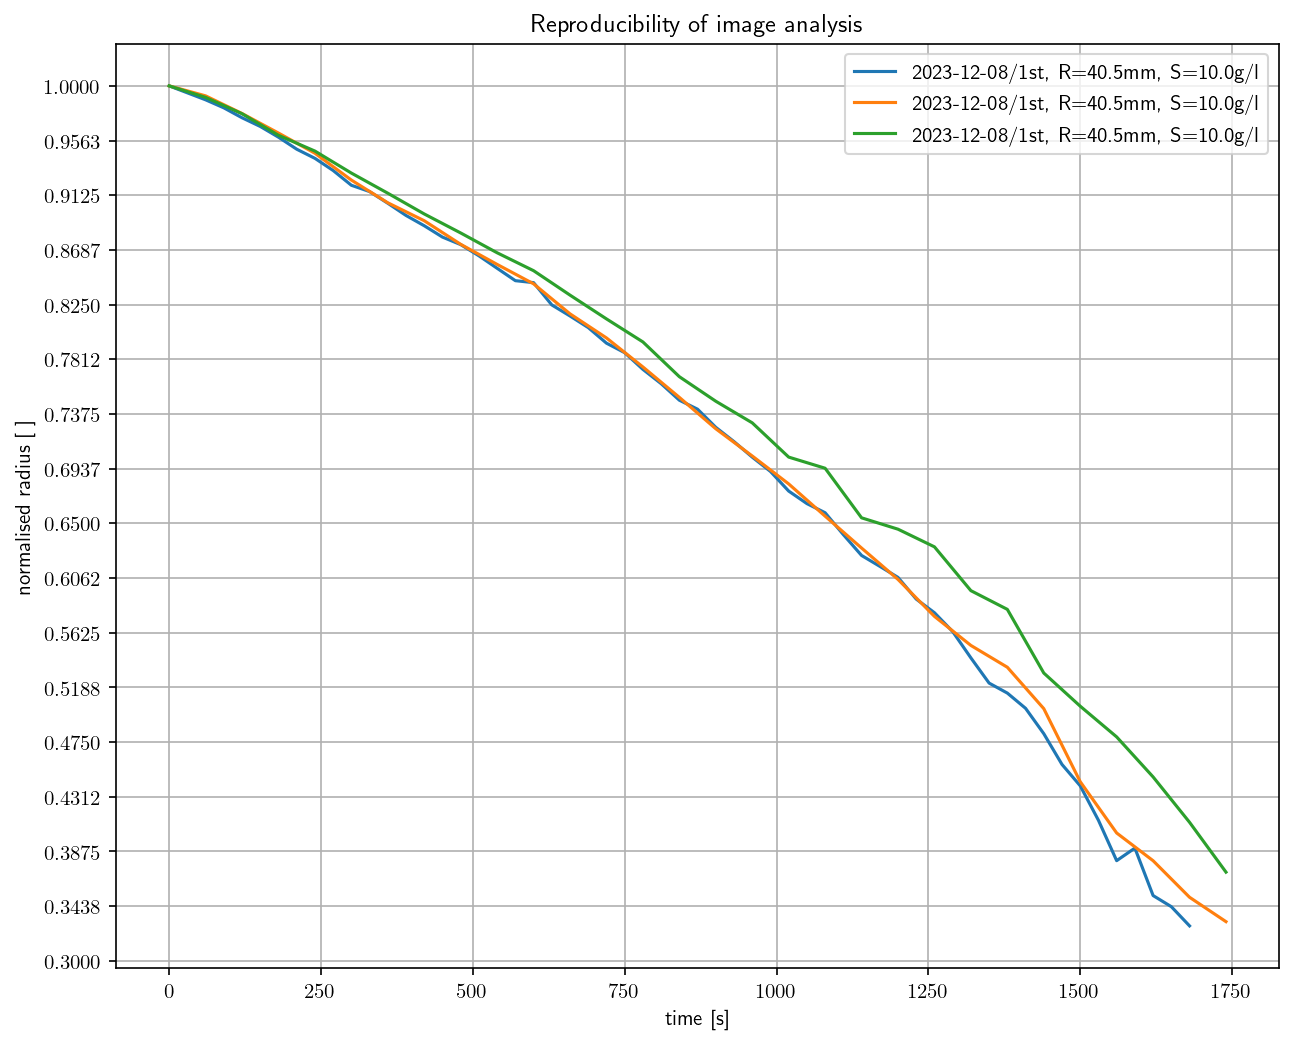

In [ ]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'

cylinder = '2023-12-08/1st'

plt.figure(figsize=(10,8),dpi=150)
plt.rcParams['text.usetex'] = True

for repetition in ['/contours/','/contours_rev1/','/contours_rev2/']:
    dirContours = directory+cylinder+repetition
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10
    # if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)

    radii = correct_outliers(radii)

    plt.plot(contours_per_shot*interval*np.arange(len(radii)),radii/radii[0],
            label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds

plt.grid()
plt.legend()
plt.yticks(ticks=np.linspace(0.3,1,17))
plt.xlabel('time [s]')
plt.ylabel('normalised radius [ ]')
plt.title('Reproducibility of image analysis')
plt.show()

# Radius vs time

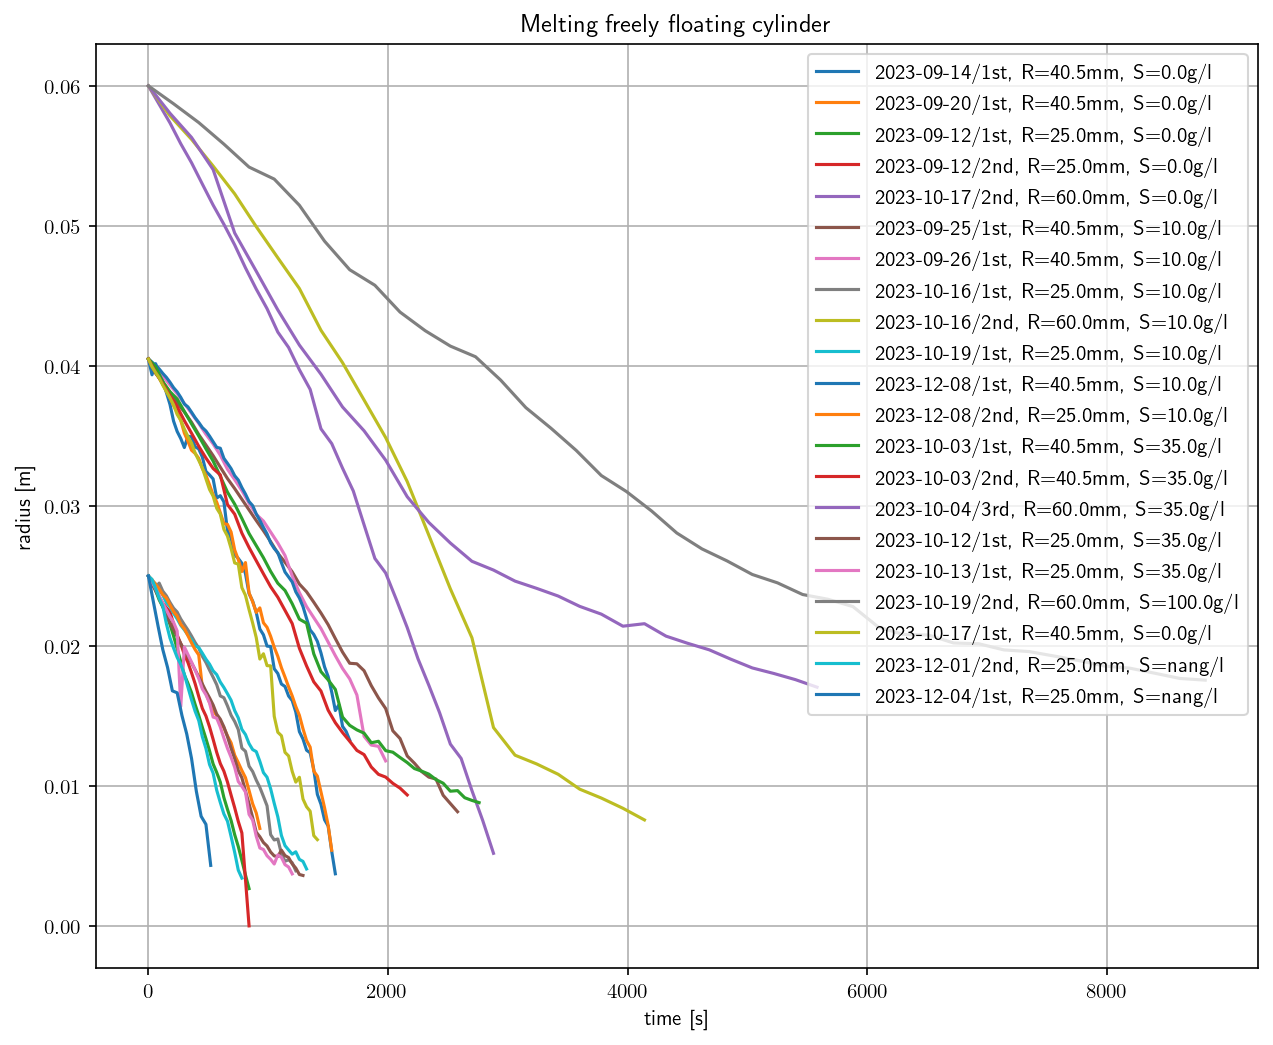

In [ ]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'

cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-09-25/1st','2023-09-26/1st','2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-10-19/2nd', # S=100
             '2023-10-17/1st', # NR
             '2023-12-01/2nd','2023-12-04/1st']# D2O

plt.figure(figsize=(10,8),dpi=150)
plt.rcParams['text.usetex'] = True

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10
    # if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    plt.plot(contours_per_shot*interval*np.arange(len(radii)),radii,
            label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds

plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('radius [m]')
plt.title('Melting freely floating cylinder')
plt.show()

## Fitting stuff to radii

20.35
20.9
20.5


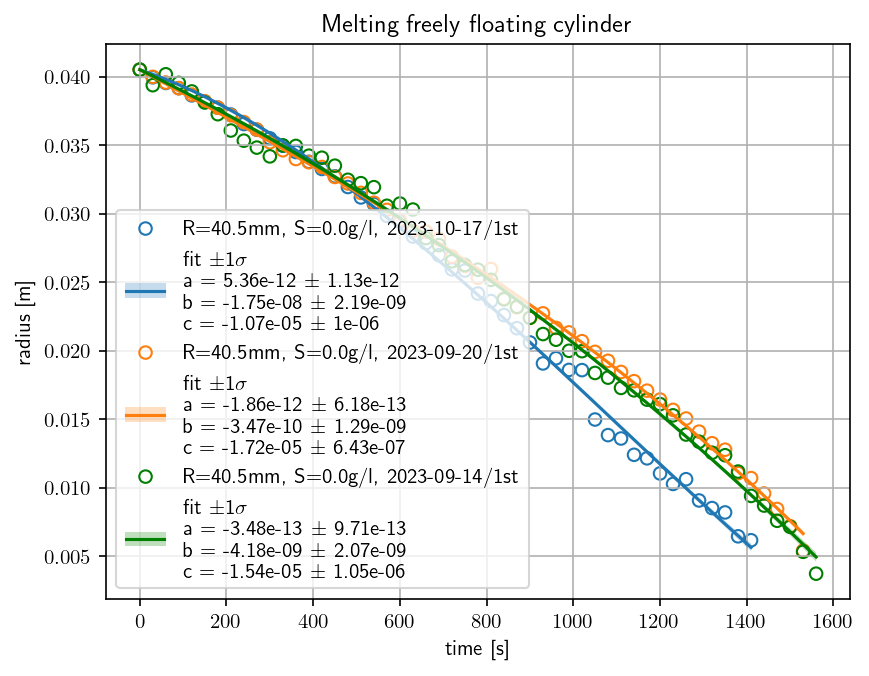

In [11]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

cylinders = ['2023-10-17/1st','2023-09-20/1st','2023-09-14/1st']

myColours = np.repeat(['tab:blue','tab:orange','green','purple','red','cyan','brown','pink','grey','olive',
                       'black','lime'],1)

plt.figure(dpi=150)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10
        
    # if exp_radius!=0.0405: continue
    # if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    plt.scatter(contours_per_shot*interval*np.arange(len(radii)),radii,
                label=f'R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l, {cylinder}',
                edgecolors=myColours[ic],facecolors='none') # one shot every 30 seconds
    
    # _ = sigmoid_fitting(contours_per_shot*interval*np.arange(len(radii)),radii,exp_y0=exp_radius,boolPlot=1)
    # _, _ = polynomial_fitting(contours_per_shot*interval*np.arange(len(radii)),radii,degree=3,boolPlot=1)
    x = contours_per_shot*interval*np.arange(len(radii))
    res, sigma = fit(func=f'np.polyval([a,b,c,{radii[0]}],x)',xdata=x[:],ydata=radii[:],color=myColours[ic],boolRetSigmas=True,legend=False,draw=1)
    print(exp_wt)

plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('radius [m]')
plt.title('Melting freely floating cylinder')
plt.show()

# Nusselt vs time

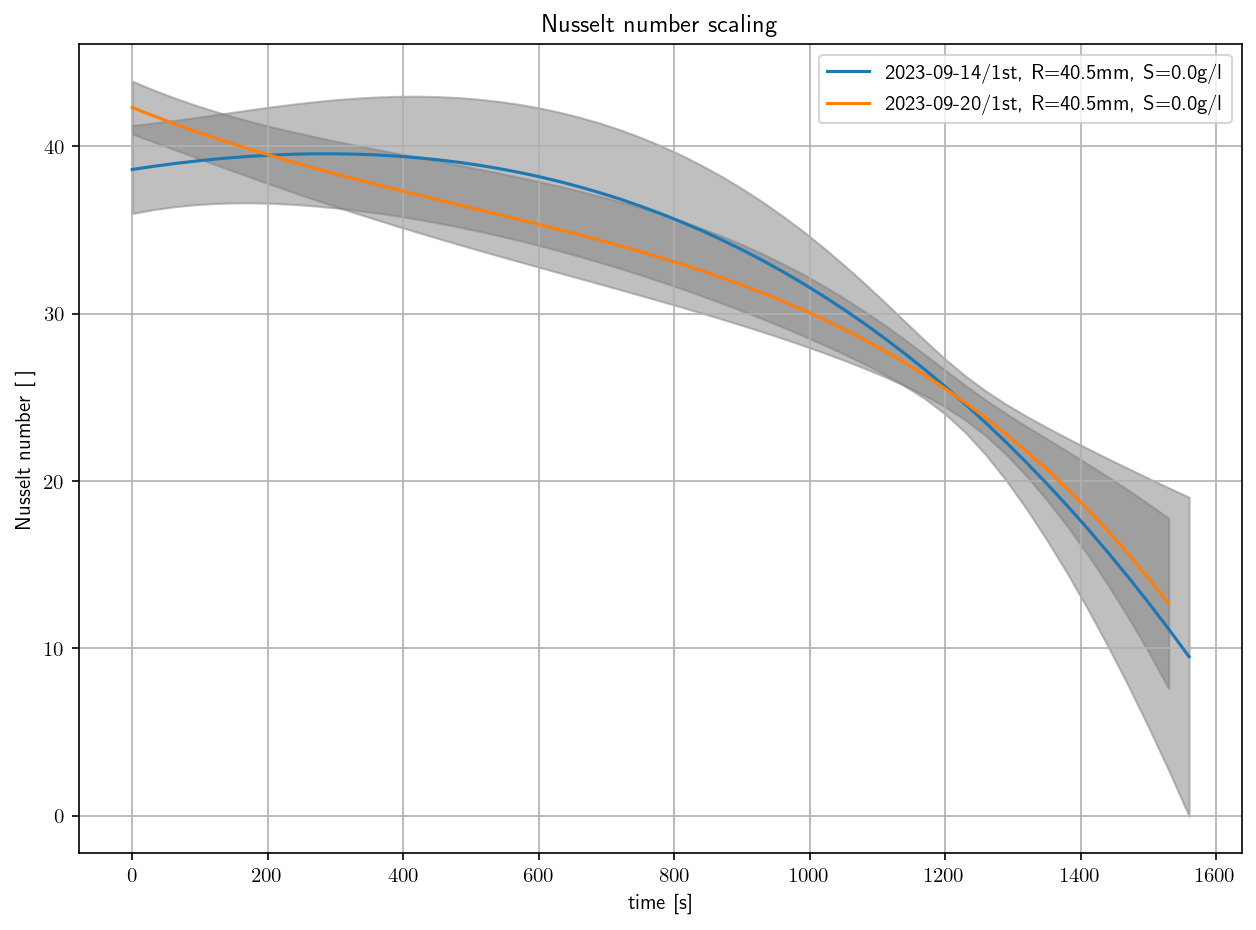

In [ ]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

plt.figure(figsize=(10,7),dpi=150)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    # print(contours_per_shot)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    if exp_radius!=0.0405 : continue
    if exp_sal!=0.0 : continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    x = contours_per_shot*interval*np.arange(len(radii))
    result, sigma = fit(func=f'np.polyval([a,b,c,{radii[0]}],x)',xdata=x,ydata=radii,draw=False,boolRetSigmas=True)
    uNusselt_numbers = uNu_fit(params=result['params'],t=x,r0=radii[0],T_water=exp_wt)
    value = np.array([i.nominal_value for i in uNusselt_numbers])
    std = np.array([i.std_dev for i in uNusselt_numbers])
    plt.plot(x,value,label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') 
    plt.fill_between(x,value+std,value-std,color='grey',alpha=0.5)
    
    # # only for bootstrapping
    # areas_fit = np.pi*result['func'](x)**2
    # uareas = unumpy.uarray(areas_fit,sigma)
    # Nusselt_numbers = uNu_areas(uareas,exp_wt,interval*contours_per_shot)
    # # error band with bootstrapping
    # for i in range(1000):
    #     a,b,c = bootstrap(result=result)
    #     if i==0: band = Nu_areas(np.pi*np.polyval([a,b,c,radii[0]],x)**2,exp_wt,interval*contours_per_shot) # these are areas that get fed to the nusselt number calculator
    #     band = np.vstack((band,Nu_areas(np.pi*np.polyval([a,b,c,radii[0]],x)**2,exp_wt,interval*contours_per_shot)))
    # std_band = np.std(band,axis=0)
    # a,b,c = result['params']['a']['value'],result['params']['b']['value'],result['params']['c']['value']
    # best_fit = Nu_areas(np.pi*np.polyval([a,b,c,d],x)**2,exp_wt,interval*contours_per_shot)
    # plt.fill_between(x,best_fit+std_band,best_fit-std_band,
    #                  color='grey',alpha=0.5)
    
plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Nusselt number [ ]')
plt.title('Nusselt number scaling')

plt.show()

# Nusselt vs Rayleigh (with perimenter as well )

/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/codes/floatingIce/functions.py:68: RuntimeWarning: invalid value encountered in sqrt
  Adot = (3*a_a*t**2+2*a_b*t+a_c) * np.sqrt((a_a.nominal_value*t**3 + a_b.nominal_value*t**2 + a_c.nominal_value*t + a0)/np.pi)


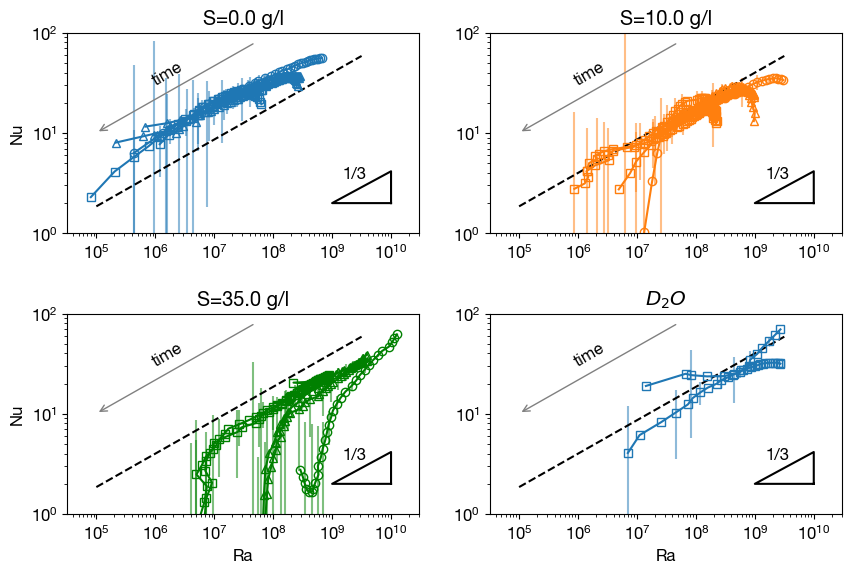

In [5]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd','2023-10-17/1st', # S=0, last is NR
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

myColours = np.repeat(['tab:blue','tab:orange','green','purple','red','cyan','brown','pink','grey','olive',
                       'black','lime'],1)
myMarkers = ['s','^','o']

chosen_radii = [0.025,0.0405,0.06]
chosen_salts = [0.,10.,35.,]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,6.25),gridspec_kw={'wspace':0.2,'hspace':0.4})

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    radii = []
    perimeters = []
    areas = []
    heights = []
    for it,contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        polygon = Polygon(contour)
        radius = np.sqrt(polygon.area/np.pi)
        radii.append(radius)    
        perimeters.append(float(polygon.length))
        areas.append(polygon.area)
        heights.append(max(contour[:,1])-min(contour[:,1]))
    
    radii = correct_outliers(radii)
    height = correct_outliers(heights,precision=.1)
    # perimeters = correct_outliers(perimeters)

    conversion = info[1,1]/radii[0] # m/px
    radii = np.array(radii)
    radii *= conversion
    perimeters = np.array(perimeters)
    perimeters *= conversion
    areas = np.array(areas)
    areas *= conversion**2
    heights = np.array(heights)
    heights *= conversion

    if exp_sal == 0.:
        axi = ax.flatten()[0]
    elif exp_sal == 10.:
        axi = ax.flatten()[1]
    elif exp_sal == 35.:
        axi = ax.flatten()[2]
    elif np.isnan(exp_sal):
        axi = ax.flatten()[3]

    Rayleigh_numbers = Ra_salinity(np.sqrt(areas),0,exp_wt,S=exp_sal)
    # Rayleigh_numbers = Ra_salinity(heights,0,exp_wt,S=exp_sal)
    if np.isnan(exp_sal): Rayleigh_numbers=Ra_heavyWater(np.sqrt(areas),exp_wt)
    if exp_sal==35.: Rayleigh_numbers = np.where(Rayleigh_numbers<1e6,np.nan,Rayleigh_numbers) # stupid line to remove a nasty outlier
    
    x = contours_per_shot*interval*np.arange(len(radii))
    a_result, a_sigma = fit(func=f'np.polyval([a,b,c,{areas[0]}],x)',xdata=x,ydata=areas,draw=False,boolRetSigmas=True)
    p_result, p_sigma = fit(func=f'np.polyval([a,b,c,{perimeters[0]}],x)',xdata=x,ydata=perimeters,draw=False,boolRetSigmas=True)
    uNusselt_numbers = uNu_fit_per(a_params=a_result['params'],p_params=p_result['params'],t=x,a0=areas[0],p0=perimeters[0],T_water=exp_wt)
    value = np.array([i.nominal_value for i in uNusselt_numbers])
    std = np.array([i.std_dev for i in uNusselt_numbers])
    # axi.fill_between(Rayleigh_numbers,value+std,value-std,
    #                  color=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]],
    #                  alpha=0.5)
    markers, caps, bars = axi.errorbar(x=Rayleigh_numbers,y=value,yerr=[0+element*int(i%3/2) for i,element in enumerate(std)], # the error plots an error bar every 3 data points
                 color=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]],
                 mfc='none',
                 marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],)
    [bar.set_alpha(0.5) for bar in bars]
    if not np.isnan(exp_sal):
        axi.set_title(f'S={exp_sal} g/l')
    else:
        axi.set_title(r'$D_2O$')
    
text_loc=[]
for ia,axi in enumerate(ax.flatten()):
    axi.plot(np.logspace(5,9.5,50),0.04*np.logspace(5,9.5,50)**(1/3),linestyle='--',c='k',label=r'$Nu=Ra^{1/3}$')
    axi.plot([1e10,1e10,1e9,1e10],[2,10**(1/3)+2,2,2],c='k')
    # axi.text(s=r'1/3',x=1.5e9,y=3.5)
    # axi.annotate(text='', xy=(5e7,8e1), xytext=(1e5,8e1), arrowprops=dict(arrowstyle='<-',color='Grey'))
    axi.text(s=r'1/3',x=1.5e9,y=3.5)
    axi.annotate(text='', xy=(5e7,8e1), xytext=(1e5,1.007e1), arrowprops=dict(arrowstyle='<-',color='Grey'))
    axi.text(s='time',x=8e5,y=3e1,rotation=30)
    axi.set(ylabel='Nu', xlabel='Ra',
            yscale='log',xscale='log',
            xlim=(10**4.5,3e10),ylim=(1e0,1e2))
    if axi == ax.flatten()[0] or axi == ax.flatten()[1]:
        axi.set_xlabel('')
    if axi == ax.flatten()[1] or axi == ax.flatten()[3]:
        axi.set_ylabel('')

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/NuRa.pdf',format='pdf',bbox_inches='tight')
plt.show()

# Plot all contours

### Freshwater

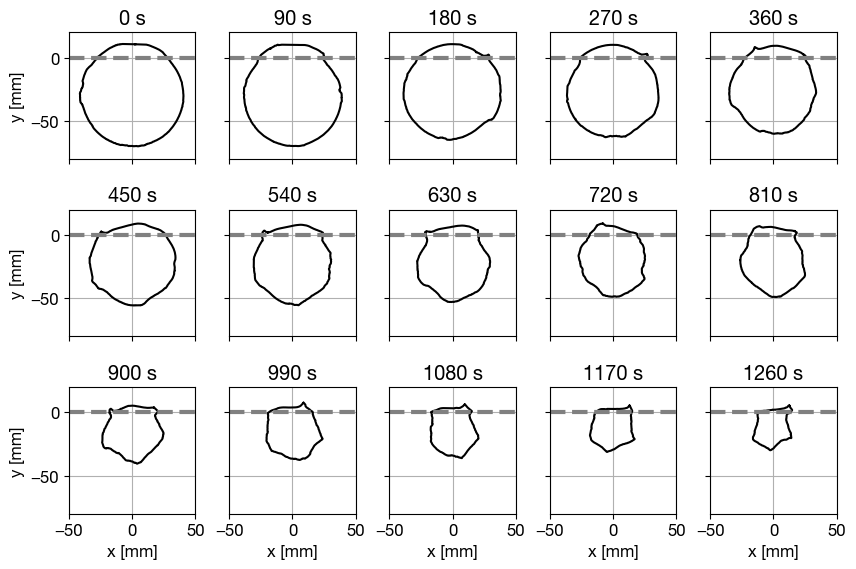

20.9 5.11e+07


In [4]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-20/'
cylinders = ['1st']

fig, ax = plt.subplots(nrows=3,ncols=5,figsize=(10,6.25),gridspec_kw={'wspace':0.2,'hspace':0.4})

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))

    radii = []
    step = 3
    for it,contourPATH in enumerate(contoursPATH[:-7:step]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        xcenter = np.mean(contour,axis=0)[0]

        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        ax.flatten()[it].plot(contour[:,0]-xcenter,contour[:,1]-wl,c='k')
        ax.flatten()[it].hlines(0,-50,50,linestyles='--',linewidth=3,colors='grey')

for it,axi in enumerate(ax.flatten()):
    axi.set(aspect='equal',
            xlabel='x [mm]',ylabel='y [mm]',
            title = f'{it*30*step} s',
            ylim=(-80,20),xlim=(-50,50),
            )
    if it%5!=0: 
        axi.set_ylabel('')
        axi.set_yticklabels('')
    if it<10:
        axi.set_xlabel('')
        axi.set_xticklabels('')
    axi.grid()

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/freshWater.pdf',format='pdf',bbox_inches='tight')
plt.show()
print(exp_wt,f'{Ra(exp_radius,0,exp_wt):.2e}')

### Heavy water

18.700000000000003 4.87e+08


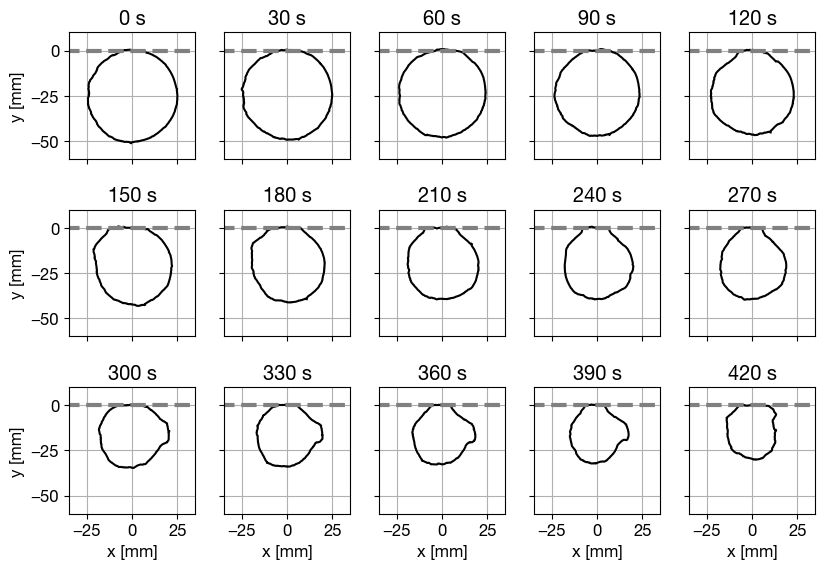

In [6]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/'
cylinders = ['2nd']

fig, ax = plt.subplots(nrows=3,ncols=5,figsize=(10,6.25),gridspec_kw={'wspace':0.0,'hspace':0.4})

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    print(exp_wt,f'{Ra_heavyWater(exp_radius,exp_wt):.2e}')

    radii = []
    step = 1
    for it,contourPATH in enumerate(contoursPATH[::step]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*8/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        xcenter = np.mean(contour,axis=0)[0]
        
        if it==len(ax.flatten()):break
        wl = findWL(contour,densityRatio=1003/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        ax.flatten()[it].plot(contour[:,0]-xcenter,contour[:,1]-wl,c='k')
        ax.flatten()[it].hlines(0,-50,50,linestyles='--',linewidth=3,colors='grey')

for it,axi in enumerate(ax.flatten()):
    axi.set(aspect='equal',
            xlabel='x [mm]',ylabel='y [mm]',
            title = f'{it*30*step} s',
            ylim=(-60,10),xlim=(-35,35),
            )
    if it%5!=0: 
        axi.set_ylabel('')
        axi.set_yticklabels('')
    if it<10:
        axi.set_xlabel('')
        axi.set_xticklabels('')
    axi.grid()

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/heavyWater.pdf',format='pdf',bbox_inches='tight')
plt.show()

### Salty water and no rotation

18.45 3.72e+07
20.35 4.78e+07


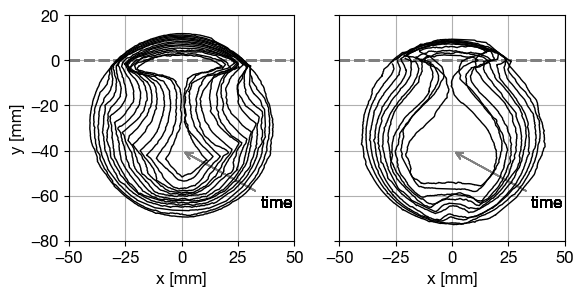

In [5]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(6.4,3.2))

# salty water
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-08/'
cylinders = ['1st']

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    print(exp_wt,f'{Ra(exp_radius,0,exp_wt):.2e}')

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::4]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*3.5/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        com,_ = hydrostasy(contour,densityRatio=917/1005)
        xcenter = com.x
        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        axs[0].plot(contour[:,0]-xcenter,contour[:,1]-wl,c='k',zorder=10,linewidth=1)
        axs[0].hlines(0,-50,50,linestyles='--',linewidth=2,colors='grey')
        axs[0].annotate(text='time', xy=(0,-40), xytext=(35,-65), arrowprops=dict(arrowstyle='->',color='Grey'))

# no rotation
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-10-17/'
cylinders = ['1st']

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    print(exp_wt,f'{Ra(exp_radius,0,exp_wt):.2e}')

    radii = []
    for it,contourPATH in enumerate(contoursPATH[:-15:3]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        com,_ = hydrostasy(contour,densityRatio=917/1005)
        xcenter = com.x
        axs[1].plot(contour[:,0]-xcenter,contour[:,1]-wl,c='k',zorder=10,linewidth=1)
        axs[1].hlines(0,-50,50,linestyles='--',linewidth=2,colors='grey')
        axs[1].annotate(text='time', xy=(0,-40), xytext=(35,-65), arrowprops=dict(arrowstyle='->',color='Grey'))

# plot
for axi in axs:
    axi.set(aspect='equal',
            xlim=(-50,50),ylim=(-80,20),
            xlabel='x [mm]')
    axi.grid()
axs[0].set_ylabel('y [mm]')
axs[1].set_yticklabels('')

plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/saltyWater_and_NR.pdf',format='pdf',bbox_inches='tight')
plt.show()

# Find waterline

### Test on one contour

/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/codes/floatingIce/functions.py:416: RuntimeWarning: invalid value encountered in double_scalars
  ratio = newArea/originalArea


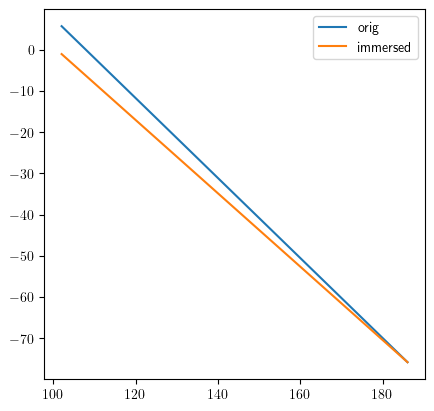

In [32]:
plt.figure()
contour = np.genfromtxt(contoursPATH[1],dtype='float',delimiter=',').T
shift = (max(contour[:,1])-min(contour[:,1]))*4/3
contour[:,1 ] = -contour[:,1] + shift 

plt.plot(contour[:,0],contour[:,1],label='orig')



immersedPG = makePolygonBelow(contour,findWL(contour))
plt.plot(immersedPG[:,0],immersedPG[:,1],label='immersed')


plt.legend()
plt.gca().set_aspect('equal')
plt.show()

### Apply to all contours

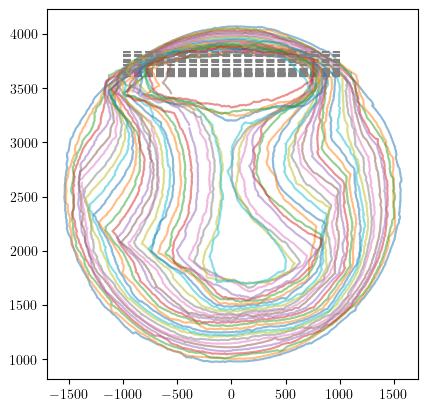

In [33]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-26/'
cylinders = ['1st']

plt.figure()

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
        contour[:,1 ] = -contour[:,1] + shift
        # plt.plot(contour[:,0],contour[:,1])
        xcenter = np.mean(contour,axis=0)[0]
        # plt.scatter(np.mean(contour,axis=0)[0],np.mean(contour,axis=0)[1])
        plt.plot(contour[:,0]-xcenter,contour[:,1],alpha=.5)

        wl = findWL(contour)
        plt.hlines(wl,-1000,1000,linestyles='--',colors='grey')


plt.gca().set_aspect('equal')

plt.show()

4.0 3.140331156954754 2.8284271247461903


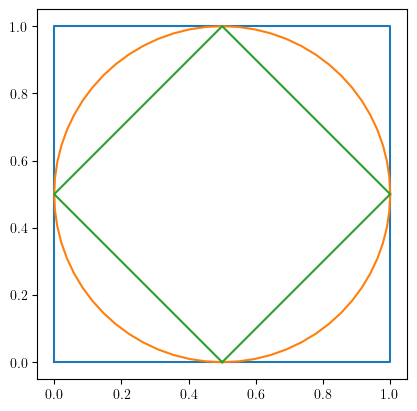

In [71]:
# check perimeter
from shapely import Point
square = Polygon([[0,0],[1,0],[1,1],[0,1]])
circle = Point(0.5,0.5).buffer(.5)
rombo = Polygon([[.5,0],[1,.5],[.5,1],[0,.5]])
plt.plot(*square.exterior.xy)
plt.plot(*circle.exterior.xy)
plt.plot(*rombo.exterior.xy)
print(square.length,circle.length,rombo.length)
plt.gca().set_aspect('equal')

In [70]:
# check uncertainty
a = ufloat(1,0.1)
b = ufloat(1,0.1)
print(a,b,a+b)

1.00+/-0.10 1.00+/-0.10 2.00+/-0.14


In [52]:
np.sqrt(0)

0.0